In [76]:
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
import cartopy.crs as ccrs
import colormaps as clm
import matplotlib as mpl

# データの準備

In [21]:
path = "/docker/mnt/d/research/D2/cnn3/predictant/continuous/pr_1x1_std_MJJASO_thailand.npy"

In [22]:
x = np.load(path)
print(x.shape)

(42, 165, 20, 20)


In [48]:
AWI = x[0, :, :, :].reshape(165, 400)
AWI = AWI.T
print(AWI.shape)

(400, 165)


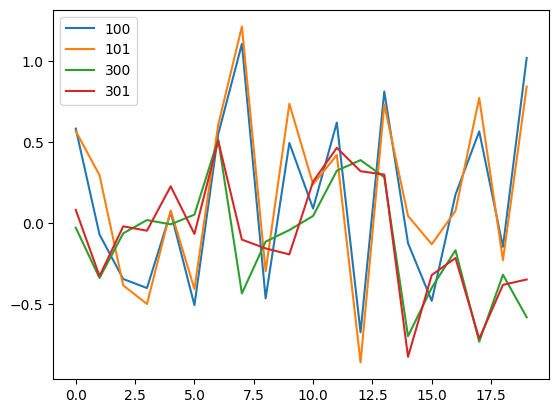

In [49]:
grid_list = [100,
             101,
             300,
             301,]
for i in grid_list:
    plt.plot(AWI[i, :20] ,label=f"{i}")
plt.legend()
plt.show()

# クラスタリング実行

In [131]:
n = 10 # クラスタ数

km_dtw = TimeSeriesKMeans(n_clusters=n,
                          random_state=42,
                          metric="dtw")

In [132]:
# タプルだからarrayに直さないといけない
# fit_predictは0次元目を観測点，1次元目を時系列データとして認識する

awi_labels = km_dtw.fit_predict(AWI)
awi_flat = awi_labels[:]
awi_map = np.reshape(awi_flat, (20, 20))
print(label_flat.shape, awi_flat)

(400,) [0 0 9 1 9 3 3 3 3 3 6 6 6 6 6 6 6 6 6 6 0 0 0 7 3 3 3 3 3 3 3 6 6 6 6 6 6
 6 6 6 0 0 0 0 3 3 3 3 3 3 3 3 6 6 6 6 6 6 6 6 0 0 0 0 0 3 3 3 3 3 3 3 3 3
 6 6 6 6 8 8 0 0 0 0 0 0 3 3 3 3 3 3 3 3 6 6 8 8 8 8 0 0 0 0 0 0 0 0 3 3 3
 3 3 3 3 8 8 8 8 8 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 8 8 8 8 8 1 1 1 1 5 0 0 0
 2 2 2 2 2 2 2 2 8 8 8 8 7 1 1 1 1 1 5 5 5 5 5 2 2 2 2 2 2 8 8 8 7 1 1 1 1
 1 1 5 5 5 5 5 2 2 2 2 2 2 8 8 7 1 1 1 1 1 1 1 5 5 5 5 2 2 2 2 4 4 2 8 7 7
 7 1 1 1 1 1 1 5 5 5 5 2 4 4 4 4 4 4 7 7 7 7 1 1 1 1 1 5 5 1 5 4 4 4 4 4 4
 4 7 7 7 7 7 1 1 1 1 5 1 1 1 5 4 4 4 4 4 4 7 7 7 7 7 1 1 1 1 1 1 1 1 1 4 4
 4 4 2 7 7 7 7 7 7 7 1 1 1 1 1 1 1 1 1 4 4 4 7 1 7 7 7 7 7 7 7 1 9 9 9 7 1
 1 1 1 9 9 1 1 9 9 9 9 9 7 7 9 9 9 9 9 1 1 1 1 1 1 1 1 9 9 9 9 9 9 9 9 9 9
 9 4 9 1 1 1 1 1 1 1 9 9 9 9 9 9 9 9 9 9 9 4 9 9 1 1 1 1 1 1]


# Elbow method

In [140]:
def elbow(data):
    distortions = []
    for i in range(1, 11):
        km_elb = TimeSeriesKMeans(n_clusters=i,
                                  random_state=42,
                                  metric="dtw")
        km_elb.fit(data)
        distortions.append(km_elb.inertia_)
        print(f"cluster {i} done")
    
    plt.plot(range(1, 10), distortions, marker='o')
    plt.show()

In [ ]:
elbow(AWI)

# 可視化

In [133]:
def draw_map(label, cluster_num=5):
    plt.rcParams["font.size"] = 18
    projection = ccrs.PlateCarree(central_longitude=180)
    img_extent = (-90, -70, 5, 25)
    
    mpl.colormaps.unregister('sandobox')
    #mpl.colormaps.register(clm.temps, name='sandbox')
    cm = plt.cm.get_cmap('sandbox', cluster_num)

    fig = plt.figure()
    ax = plt.subplot(projection=projection)
    ax.coastlines()
    mat = ax.matshow(label,
                     origin='upper',
                     extent=img_extent,
                     transform=projection,
                     cmap=cm,
                    )
    cbar = fig.colorbar(mat, ax=ax)
    plt.show()

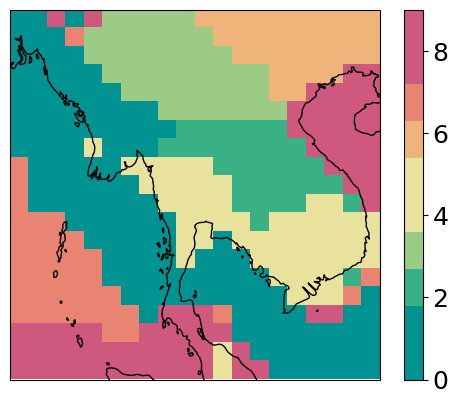

In [134]:
draw_map(awi_map, cluster_num=n)

In [137]:
def plot_km(data, labels, km, cluster_num=3):
    fig, axes = plt.subplots(n, figsize=(8, 18))
    plt.subplots_adjust(hspace=0.5)
    for i in range(cluster_num):
        ax = axes[i]
        for xx in data[labels == i]:
            ax.plot(xx.ravel()[:10], "k-", alpha=.01)
        ax.plot(km.cluster_centers_[i].ravel()[:10], "r-")
    plt.show()

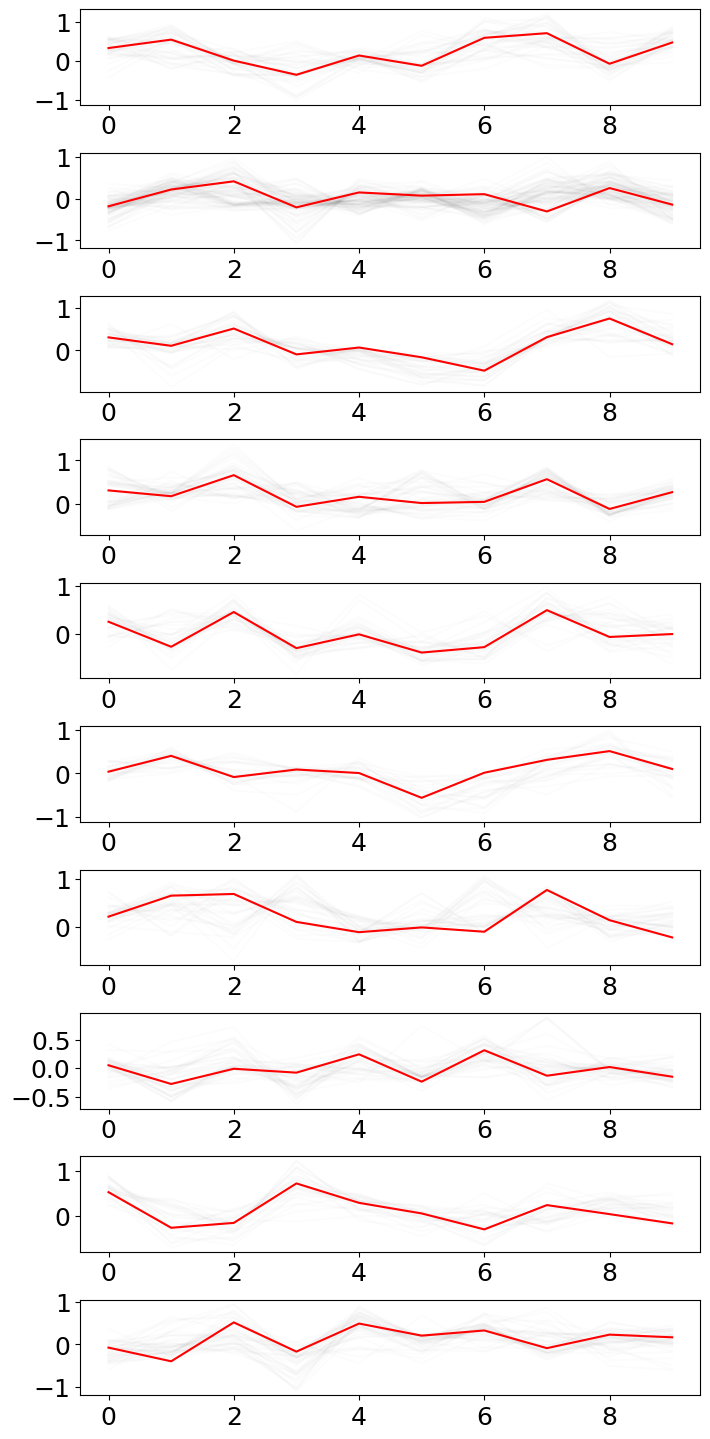

In [138]:
plot_km(AWI, awi_labels, km_dtw, cluster_num=n)

# 比較実験

(400,) [0 1 1 1 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2
 2 2 2 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 2 0 0 0 0 0 0 0 1 1 1 1 1 2 2
 2 2 2 2 2 2 0 0 0 0 1 1 1 1 2 1 1 1 2 2 2 2 2 2 2 2 0 0 0 0 0 1 1 1 1 1 1
 2 2 2 2 2 2 2 2 1 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 1 1 0 0 0 0 1 1 1 1
 2 1 2 2 2 2 2 2 2 2 1 1 1 0 1 1 1 0 1 0 1 2 2 2 2 2 2 1 0 0 1 2 0 0 0 1 1
 1 0 1 1 1 2 2 2 2 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 2 2 2 1 1 1 1 1 1 1 0 0
 1 0 0 1 2 1 1 1 2 2 2 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 2 1 2 1 1 1 1 2 1 1
 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


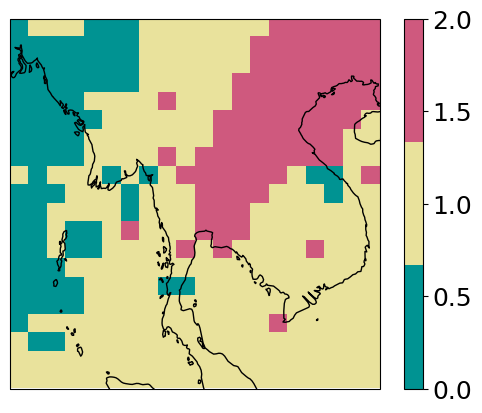

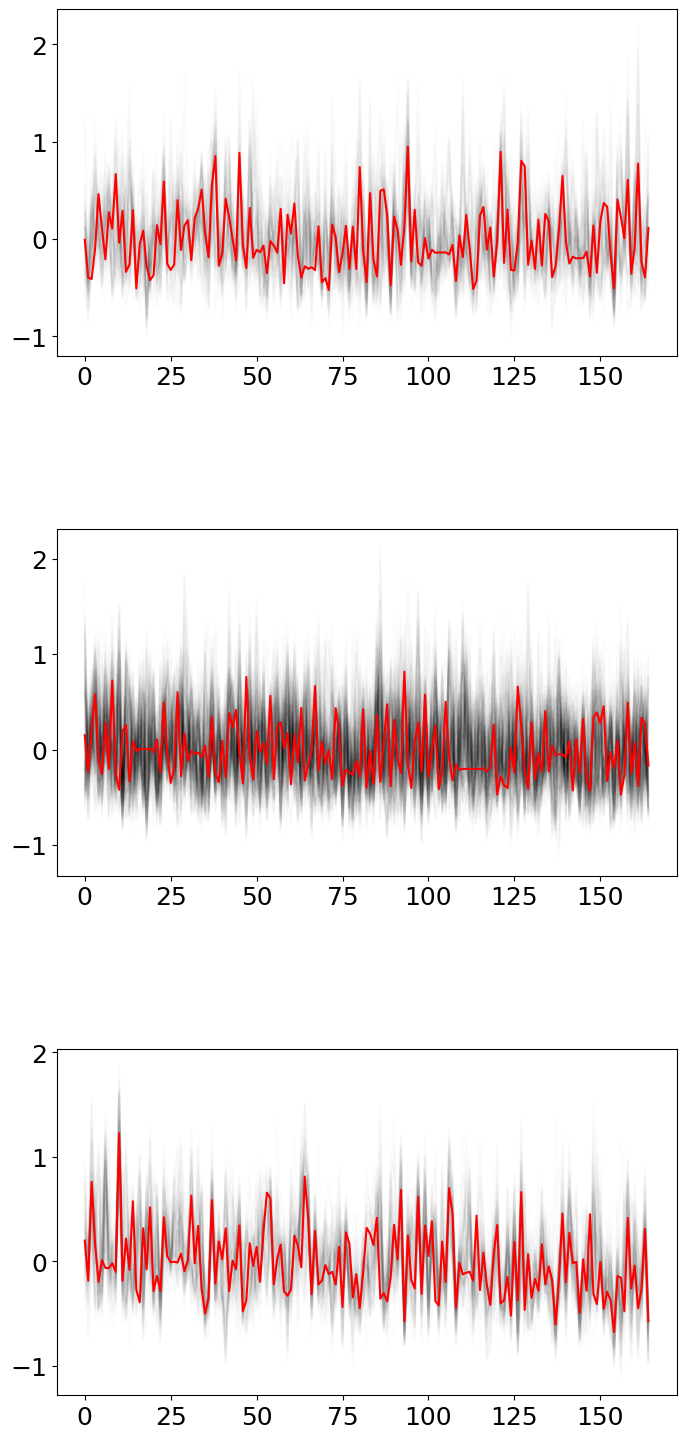

In [105]:
BCC = x[1, :, :, :].reshape(165, 400)
BCC = BCC.T
bcc_labels = km_dtw.fit_predict(BCC)
bcc_flat = bcc_labels[:]
bcc_map = np.reshape(bcc_flat, (20, 20))
print(label_flat.shape, bcc_flat)
draw_map(bcc_map, cluster_num=n)
plot_km(BCC, bcc_labels, km_dtw, cluster_num=n)

(400,) [4 0 0 6 6 6 6 6 6 6 6 1 1 1 1 1 1 1 6 6 0 0 0 6 6 6 6 6 6 6 1 1 1 1 1 1 1
 1 6 6 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 0 0 6 0 0 0 0 0 3 1 1 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 3 3 3 1 1 1 1
 1 1 1 1 0 0 0 0 0 3 3 3 3 3 3 3 1 1 1 2 2 2 2 2 6 6 6 6 6 3 3 3 3 3 3 3 2
 2 2 2 2 2 2 2 6 6 6 6 6 3 3 3 3 3 3 4 2 2 2 2 2 2 2 2 6 6 6 6 6 3 3 3 3 3
 4 4 2 2 2 2 2 2 2 6 6 6 6 6 6 3 3 3 3 3 4 4 2 2 2 2 2 2 2 6 6 6 6 6 6 3 3
 3 3 4 4 4 2 2 2 2 2 2 6 6 6 6 6 6 6 3 3 4 4 4 4 4 1 1 2 2 2 6 6 6 6 6 6 6
 6 4 4 4 4 4 4 4 4 1 1 1 1 6 6 6 6 6 6 6 6 4 4 4 4 4 4 4 4 1 0 0 0 3 6 6 6
 6 6 6 6 4 4 4 4 4 4 4 4 4 0 0 0 0 6 6 6 6 6 6 3 4 4 4 4 4 4 4 4 4 4 0 0 0
 5 5 5 6 6 3 3 4 4 4 4 4 4 4 4 3 3 5 5 5 5 5 5 5 5 5 3 4 4 4 4 4 4 4 4 3 3
 5 5 5 5 5 5 5 5 5 5 0 0 4 4 4 4 4 4 3 3 5 5 5 5 5 5 5 5 5 5]


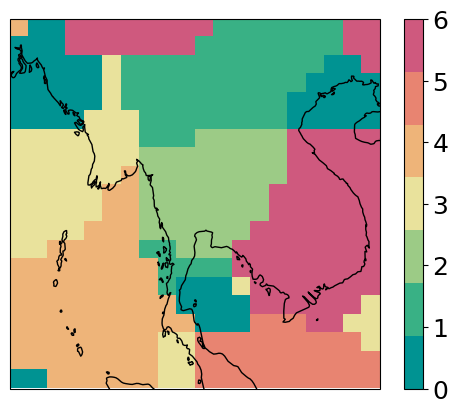

In [91]:
BCC2 = x[2, :, :, :].reshape(165, 400)
BCC2 = BCC2.T
bcc2_labels = km_dtw.fit_predict(BCC2)
bcc2_flat = bcc2_labels[:]
bcc2_map = np.reshape(bcc2_flat, (20, 20))
print(label_flat.shape, bcc2_flat)
draw_map(bcc2_map, cluster_num=n)
plot_km(BCC, bcc_labels, km_dtw, cluster_num=n)

(400,) [0 0 0 0 0 0 0 0 6 6 6 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 6 6 2 2 2 2 2 2 2
 2 2 2 0 0 0 0 0 0 0 3 3 3 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 3 3 3 2 2 2 2
 2 2 2 2 2 6 0 0 0 0 0 0 0 3 3 3 2 2 2 2 2 2 2 2 2 6 0 0 0 0 0 0 3 3 3 3 3
 3 2 2 2 2 2 6 6 6 0 0 0 0 0 0 3 3 3 3 3 3 3 3 2 2 6 6 6 6 0 0 0 0 0 0 3 3
 3 3 3 3 3 3 3 3 4 4 4 3 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 4 4 4 4 4 0 0 0 0 0
 0 0 3 3 3 3 3 3 3 3 4 4 4 4 4 0 0 0 0 0 0 3 3 3 3 3 3 3 3 4 4 4 4 4 4 0 0
 0 0 0 6 6 6 6 6 6 6 6 4 4 4 4 4 4 4 0 1 1 1 6 6 6 6 6 6 6 6 6 4 4 4 4 4 4
 4 1 1 1 1 1 6 6 6 6 6 6 6 6 6 4 4 4 4 4 4 1 1 1 1 1 1 1 6 6 6 6 6 6 6 6 6
 4 4 4 4 1 1 1 1 1 1 1 1 6 6 6 6 6 6 6 6 3 3 3 3 1 1 1 1 1 1 1 1 6 6 6 1 1
 1 3 3 3 3 3 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 1 1 1 1 4 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 4]


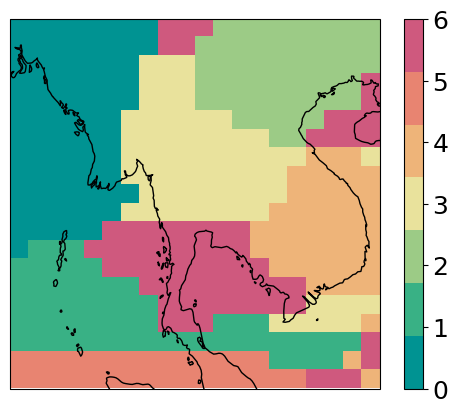

In [90]:
CAS = x[3, :, :, :].reshape(165, 400)
CAS = CAS.T
cas_labels = km_dtw.fit_predict(CAS)
cas_flat = cas_labels[:]
cas_map = np.reshape(cas_flat, (20, 20))
print(label_flat.shape, cas_flat)
draw_map(cas_map, cluster_num=n)

In [ ]:
CAS = x[3, :, :, :].reshape(165, 400)
CAS = CAS.T
cas_labels = km_dtw.fit_predict(CAS)
cas_flat = cas_labels[:]
cas_map = np.reshape(cas_flat, (20, 20))
print(label_flat.shape, cas_flat)
draw_map(cas_map, cluster_num=n)